Load the dataset

In [1]:
from keras import datasets

(X_train, y_train),(X_test, y_test) = datasets.mnist.load_data()
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
# O/p: (no.of images, length, breadth)

X_train shape (60000, 28, 28)
y_train shape (60000,)


Display some of the images with their labels

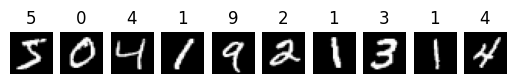

In [2]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

We need to pass each pixel as an input to the NN. Let's reshape it have a single array with 28 * 28 = 784 pixels (Each image is 28x28 pixels, flattened to 784 features.)

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# After flatting 
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (60000, 784)
X_test shape (10000, 784)


In [5]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

Now let's normalize the pixel value 

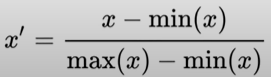

In [6]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [8]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Now we will train Siamese Network using positive and negative pairs of images. 

Positive pair: Same digits

Negative pair: Different digits

In [15]:
import numpy as np

def generate_pairs(X, y):
    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit
        # Positive pair
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive label, ground truth label is 0.
        # The distance between images representing the same digit should be small and that's why we use 0 as the label
        y_pairs.append([0])

        # Find a random image representing the different digit
        # Negative pair
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a Negative label, ground truth label is 1.
        # The distance between images representing the same digit should be large and that's why we use 1 as the label
        y_pairs.append([1])
    
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices) # So that it is not 0 and 1 in continution

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]



Generate the pair for training and testing model

In [16]:
X_train_pair, y_train_pair = generate_pairs(X_train, y_train)
X_test_pair, y_test_pair = generate_pairs(X_test, y_test)
print("X_train_pairs shape: ", X_train_pair.shape)
print("X_test_pair shape: ", X_test_pair.shape)

X_train_pairs shape:  (120000, 2, 784)
X_test_pair shape:  (20000, 2, 784)


display some of these pairs to ensure they were generated correctly

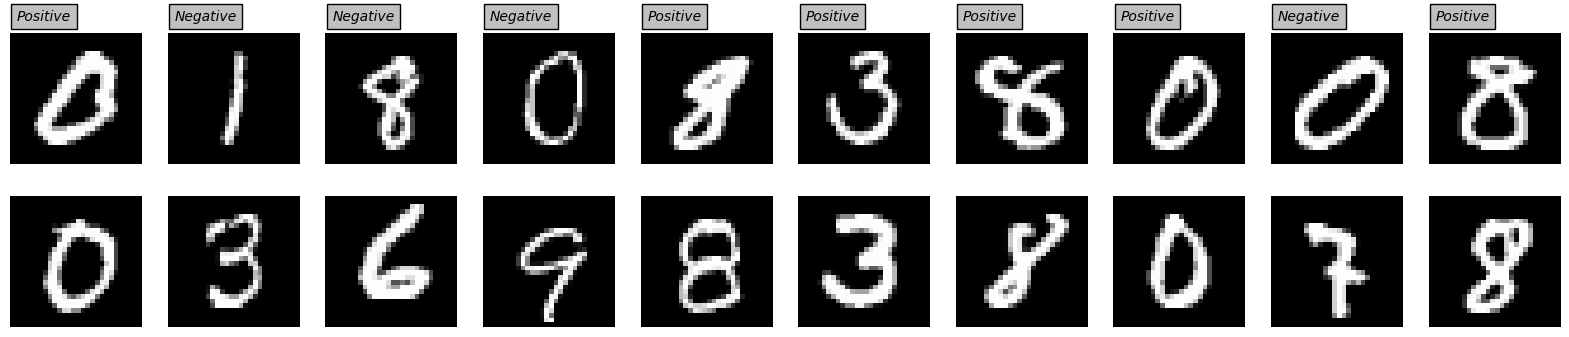

In [18]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pair, y_train_pair)

Input for the Siamese network

In [19]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

Body of the Siamese network. This will be responsible for generating embedding

In [20]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential([
    Input(shape=(784,)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation=None)
])

In [21]:
twin1 = network(input1)
twin2 = network(input2)

The output of the Siamese network is the distace between the embeddings of the two images.

We can use Lambda layer to calculate the Euclidean disatnce between the embeddings

In [22]:
from keras.layers import Lambda
from keras.ops import norm

def euclidean_distance(twins):
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis = 1, keepdims=True)

distance = Lambda(euclidean_distance)([twin1, twin2])

Setup the model

In [23]:
from keras import Model

model = Model(inputs= [input1, input2], outputs = distance)

We'll use the Contrastive Loss to train the model. 

Formula of this loss in the paper "Dimensionality Reduction by Learning an Invariant Mapping."

If the digits are same and distance is large/ if the digit are different and distance is small produce a big loss.
Else small loss.

In [25]:
from keras.ops import cast, maximum, square

def contrastive_loss(y, d):
    margin = 1
    y = cast(y, d.dtype)
    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))
    return loss

Compile the model using the Contrastive Loss

In [26]:
from keras.metrics import binary_accuracy

model.compile(loss= contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

model architecture looks like:

In [27]:
import keras

keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Fit the model

In [28]:
history = model.fit(
    x = [X_train_pair[:, 0], X_train_pair[:, 1]],
    y = y_train_pair[:],
    validation_data = ([X_test_pair[:, 0], X_test_pair[:, 1]], y_test_pair[:]),
    batch_size=32,
    epochs=5
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.8969 - loss: 0.0494 - val_binary_accuracy: 0.9647 - val_loss: 0.0216
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9780 - loss: 0.0151 - val_binary_accuracy: 0.9674 - val_loss: 0.0167
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - binary_accuracy: 0.9859 - loss: 0.0106 - val_binary_accuracy: 0.9709 - val_loss: 0.0150
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - binary_accuracy: 0.9903 - loss: 0.0081 - val_binary_accuracy: 0.9675 - val_loss: 0.0151
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - binary_accuracy: 0.9926 - loss: 0.0066 - val_binary_accuracy: 0.9676 - val_loss: 0.0145


Loss during training

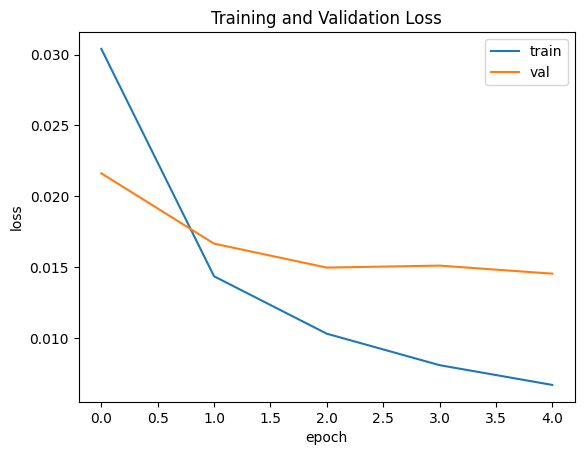

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

Evaluate the model using test data

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step


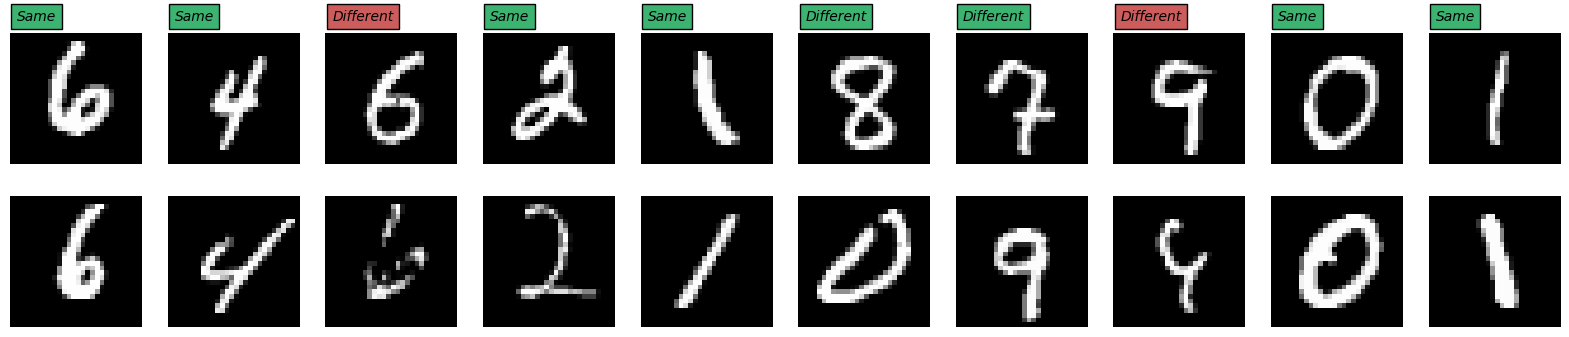

In [30]:
predictions = model.predict([X_test_pair[:, 0], X_test_pair[:, 1]]) >= 0.5
display_pairs(X_test_pair, predictions, predictions == y_test_pair)

Acurracy of the model on the test data

In [31]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pair, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


Different layers of the model we have trained:

In [32]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

Sequential model can be used to generate embedding for the image

In [33]:
embedding_model = model.layers[2]

Let's select two random images representing the digit 3, and one image representing the digit 7

In [34]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(np.int64(1628), np.int64(8337), np.int64(6561))

We can generate the embeddings for these 3 images

In [35]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Distance between the embeddings of the two images representing the digit 3 should be really small

In [36]:
norm(embedding1 - embedding2).numpy()

np.float32(0.018669222)

The distances between the embeddings of the images representing the digit 3 and the image representing the digit 7 should be large

In [38]:
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()

(np.float32(0.9249929), np.float32(0.9267308))